<h1 align="center">$\textbf{OpenMP part 2}$</h1> 

## $\textbf{Exercise 1:}$

Using your code 2D non linear convection equation from the `numba_pyccel_assignments`:
1. Parallelize the 2D non linear convection equation
2. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.stdlib.internal.openmp import omp_in_parallel, omp_get_num_threads
from pyccel.epyccel import epyccel
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
font_axis = {
    'family': 'sans-serif',
    'color':  'black',
    'weight': 'normal',
    'size': 14,
    }

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
def solve_2d_nonlinearconv_pyccel(u:'float[:,:]', un:'float[:,:]', v:'float[:,:]', vn:'float[:,:]', nt:'int',
                                  dt:'float', dx:'float', dy:'float', c:'int', n_threads:'int'):

    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    rows, cols = u.shape
    
    #$omp parallel num_threads(n_threads)    
    #$omp for 
    for n_nt in range(nt):
        un[:, :] = u[:, :]
        vn[:, :] = v[:, :]
        
        #$omp parallel for collapse(2)
        for i in range(1, rows):
            for j in range(1, cols):
                
                u[i, j] = un[i, j] - (un[i, j]*(dt/dx))*(un[i, j] - un[i-1, j])
                u[i, j] -= (vn[i, j]*(dt/dy))*(un[i, j] - un[i, j-1])
                
                v[i, j] = vn[i, j] - (un[i, j]*(dt/dx))*(vn[i, j] - vn[i-1, j])
                v[i, j] -= (vn[i, j]*(dt/dy))*(vn[i, j] - vn[i, j-1])
                
    #$omp end parallel

    return 0

In [4]:
solve_2d_nonlinearconv_pyccel_90 = epyccel(solve_2d_nonlinearconv_pyccel)

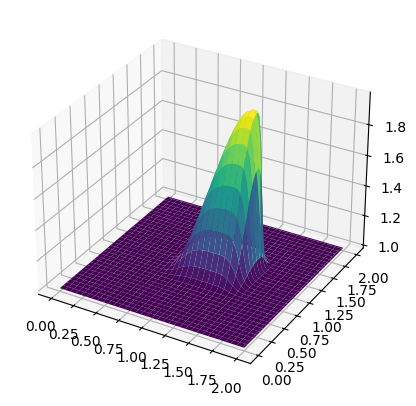

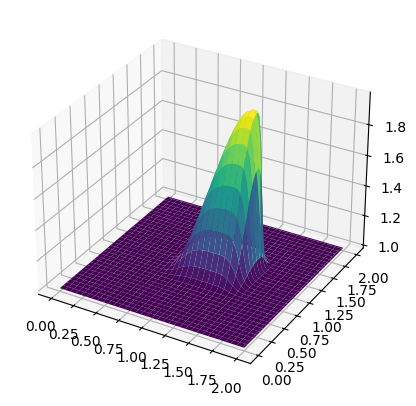

In [5]:
###variable declarations
nx = 101
ny = 101
nt = 80
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx)) ##create a 1xn vector of 1's
v = np.ones((ny, nx))
un = np.ones((ny, nx))
vn = np.ones((ny, nx))     

solve_2d_nonlinearconv_pyccel_90(u, un, v, vn, nt, dt, dx, dy, c, 5)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)


fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, v, cmap=cm.viridis)

In [6]:
%timeit solve_2d_nonlinearconv_pyccel_90

22.8 ns ± 0.535 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [7]:
from pyccel.epyccel import epyccel
    
n_threads = 16
CPU_times = []

for i_thread in range(1, n_threads):

    f_exec = epyccel(solve_2d_nonlinearconv_pyccel, language="c", accelerators="openmp")

    CPU_start = time.process_time() 

    f_exec(u, un, v, vn, nt, dt, dx, dy, c, i_thread)

    CPU_times.append(time.process_time() - CPU_start) 

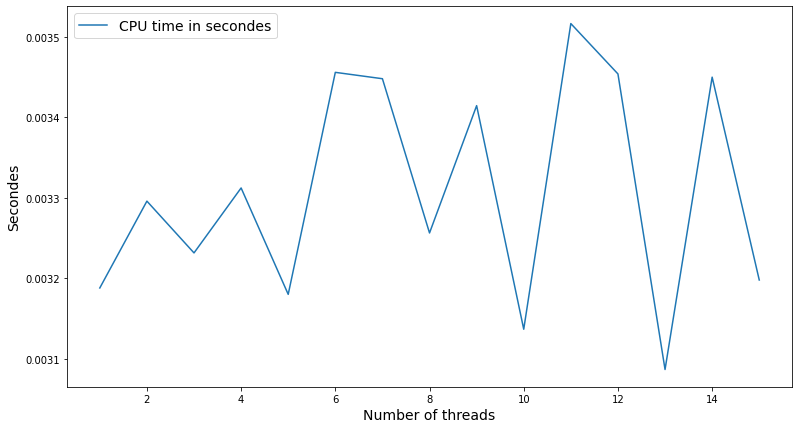

In [8]:
n_threads = 16
plt.figure(figsize=(13, 7))
threads = np.arange(1, n_threads, 1)
plt.plot(threads, CPU_times, label='CPU time in secondes')
plt.xlabel("Number of threads", fontdict=font_axis)
plt.ylabel("Secondes", fontdict=font_axis)
plt.legend(fontsize=14)
plt.show()

## $\textbf{Exercise 2:}$

Using your code Navier Stokes equation from the `numba_pyccel_assignments`:
1. Pyccelize the Navier Stokes equation (if it's not done).
2. Parallelize it using OpenMP.
3. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [9]:
from sympy.utilities.lambdify import lambdify
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from numba import njit
import time
import sympy as sp
from sympy import init_printing
init_printing(use_latex=True)

In [10]:
def cavity_flow_pyccel(nt:'int', u:'float[:,:]',un:'float[:,:]', v:'float[:,:]',vn:'float[:,:]',b:'float[:,:]',
                       dt:'float', nx:'int', ny:'int', dx:'float', dy:'float', p:'float[:,:]',pn:'float[:,:]',
                       rho:'int', nu:'float',nit:'int', n_threads:'int'):
    
    #$omp parallel num_threads(n_threads)    
    
    #$omp for collapse(2)
    for i in range(ny):
        for j in range(nx):
            b[i, j] = 0
            un[i, j] = u[i, j]
            vn[i, j] = v[i, j]
            pn[i, j] = p[i, j]

    #$omp for
    for n in range(nt):
        un[:,:] = u[:, :]
        vn[:,:] = v[:, :]
        
    row, col = p.shape
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))  
    
    pn[:,:] = p[:,:]
    #$omp for
    for q in range(nit):
        pn[:,:] = p[:,:]
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2]
        p[0, :] = p[1, :]
        p[:, 0] = p[:, 1]
        p[-1, :] = 0
        
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        
        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
    
    #$omp end parallel  


In [11]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
un = np.zeros((ny, nx))
vn = np.zeros((ny, nx))
pn = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

In [12]:
from pyccel.epyccel import epyccel

In [13]:
if __name__ == '__main__':
    import numpy as np
    import time
    CPU_times = []
    nb_threads = 17
    
    f_exec = epyccel(cavity_flow_pyccel, language="c", accelerators="openmp")
    
    for i_thread in range(1, nb_threads):
        CPU_start = time.process_time()
        
        f_exec(nt, u, un,v, vn,b,dt, nx, ny, dx, dy, p,pn, rho, nu, nit, i_thread)
        
        CPU_times.append(time.process_time() - CPU_start)

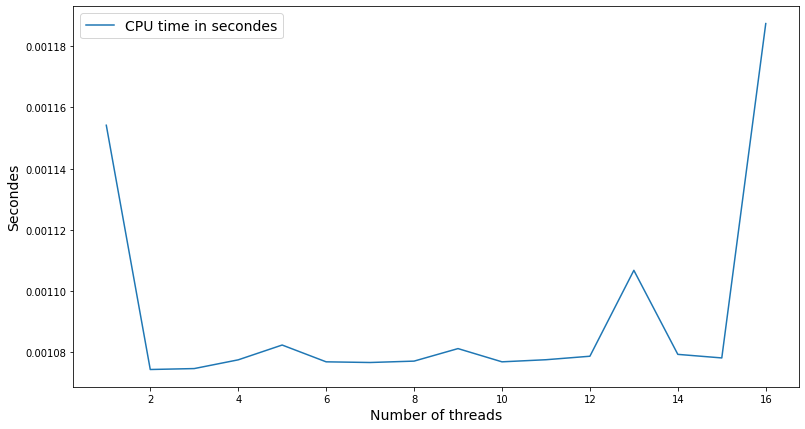

In [14]:
plt.figure(figsize=(13, 7))
threads = np.arange(1, nb_threads, 1)
plt.plot(threads, CPU_times, label='CPU time in secondes')
plt.xlabel("Number of threads", fontdict=font_axis)
plt.ylabel("Secondes", fontdict=font_axis)
plt.legend(fontsize=14)
plt.show()